# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


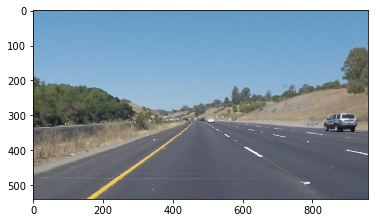

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [36]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(prev_frame, img, lines, line_color=[255, 0, 0], thickness=2):
    """
    the starting point of line draw
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    To make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    frame_info = extract_lanes_from_lines(prev_frame, lines, img.shape[0])
    lane_lines = np.concatenate( (frame_info.l_line, frame_info.r_line) )
    
    #combining all the lines into two lines
    # the left line will have a slope typically greater than the right one
    # and significantly so
    for i, line in enumerate(lane_lines):        
        for x1,y1,x2,y2 in line:
            slope, angle = get_slope_angle(x1, y1, x2, y2)
            pos=1
            pref="R: "
            if slope < 0.:
                pos=0
                pref="L: "
            print_text(img, pref + "(x: " + str(x1) + " y: " + str(y1) + ") - (" + str(x2) +  ", " + str(y2)\
                       + "), m:" + str(slope) + ", angle: " + str(angle), pos)
            cv2.line(img, (x1, y1), (x2, y2), line_color, thickness)
    return frame_info

def get_slope_angle(x1, y1, x2, y2):
    dx=x2-x1
    dy=y2-y1
    if dy==0:
        return math.inf, 90.0
    m=round(dy/dx, 2)
    angle=round(math.degrees(math.atan2(dy, dx)), 2)
    return m, angle

SLOPE_MIN=.5
SLOPE_MAX=.9
            
def extract_lanes_from_lines(prev_frame, lines, maxy=540):
    """
    In this method we extract just two lines corresponding to left and right line from 
    all the various lines. 
    Assumptions: 
    1) This is from a front facing camera so lanes will extend till bottom
    2) The slope of the left lane line will be greater than the right lane line due to convergence 
       at the distance
    3) To eliminate other lines (noise) check that the two main lines cut accross the bottom horixontal line
    
    """
    #print('num lines:', len(lines))
    slope_tol = 0.05 # tolerance for some differnce in slope
    left_slope_dict=dict() # left lines have -ve slope
    right_slope_dict=dict() # right lane lines have +ve slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, angle = get_slope_angle(x1, y1, x2, y2)            
            if slope == 0 or slope == math.inf or abs(slope) > SLOPE_MAX or abs(slope) < SLOPE_MIN: 
                continue # ignore a vertical segment its probably noise
            
            slope_dict = right_slope_dict
            if slope < 0.:
                slope_dict = left_slope_dict
                
            if len(slope_dict) > 0:
                added=False
                for key, value in slope_dict.items():
                    if abs(key-slope) < slope_tol:
                        arr=np.array([line], np.int32)
                        lv = len(value)
                        avgk = (lv*key + slope)/(lv+1)
                        value = np.concatenate((value, arr))
                        slope_dict.pop(key, None)
                        slope_dict[avgk]=value
                        added=True
                        break
                if added:
                    continue
                        
            ll=np.array([line], np.int32)            
            slope_dict[slope]=ll
    
    #find the top one from each slope dict based on item count
    l_prevs=0.
    r_prevs=0.
    if prev_frame != None:
        l_prevs= prev_frame.l_slope
        r_prevs= prev_frame.r_slope
        
    ls = get_best_slope_from_dict(l_prevs, left_slope_dict)
    rs = get_best_slope_from_dict(r_prevs, right_slope_dict)

        
    if ls==0. or rs == 0.:
        return prev_frame
    
     #combining lines1 set and lines2 set in a single long line
    m1, c1 = combine_into_single_line(ls, left_slope_dict[ls])
    m2, c2 = combine_into_single_line(rs, right_slope_dict[rs])
   
    
    if prev_frame != None:
        m1, c1 = get_avg_bw_frames(prev_frame.l_slope, prev_frame.l_c, m1, c1)
        m2, c2 = get_avg_bw_frames(prev_frame.r_slope, prev_frame.r_c, m2, c2)
    
    l_l, r_l = truncate_top_join(m1, c1, m2, c2, maxy)
    cur_frame=FrameInfo()
    cur_frame.l_slope=m1
    cur_frame.r_slope=m2
    cur_frame.l_c=c1
    cur_frame.r_c=c2
    cur_frame.l_line=l_l
    cur_frame.r_line=r_l
                      
    return cur_frame

def get_avg_bw_frames(prev_m, prev_c, cur_m, cur_c, slope_diff_lim=.005, c_diff_lim=5, weightage=9):
    """
    If there is too much diff between prev fram line and cur frame line we move in the new direction 
    by little
    weightage is 3 for the prev line to move it slowly towards the new line
    """
    
    if abs(prev_m-cur_m)<=slope_diff_lim and abs(prev_c-cur_c)<=c_diff_lim:
        return cur_m, cur_c
    
    return (prev_m*weightage+cur_m)/(weightage+1), (prev_c*weightage+cur_c)/(weightage+1)

    

def get_best_slope_from_dict(prev_slope, slope_dict, min_lines=2):
    """
    We check if prev_frame is there..
    If yes, then: 
       return the closest one, if num of lines and slope difference above some threshold
    If no:
       simply return the one with max no. of lines
    """
    rets=0.
    if prev_slope != 0.:
        sdiffmin=math.inf    
        for s, arr in slope_dict.items():
            n = len(arr)
            sdiff = abs(s-prev_slope)
            if sdiff < sdiffmin and n>=min_lines:
                sdiffmin=sdiff
                rets=s
        if rets != 0.:
            return rets
        
    smax=0
    for s, arr in slope_dict.items():
        n = len(arr)
        if n > smax:
            smax=n
            rets=s
    return rets
                
        
        

def truncate_top_join(m1, c1, m2, c2, maxy):
    """
    The triangle at the top looks bit ugly, so making the lane lines just come slightly below that
    Let y where 2 lines interesect by yi
    is yi=(c1*m2-c2*m1)/(m2-m1)
    so we curtail the line tops to yi-10
    From the bottom, we take the point at maxy
    and return the left and right lines
    """
    yi=(c1*m2-c2*m1)/(m2-m1)
    ytop=yi+15
    
    x1_ytop=(ytop-c1)/m1
    x1_maxy=(maxy-c1)/m1    
    l_l=np.array([[[x1_ytop, ytop, x1_maxy, maxy]]], np.int32)
    
    x2_ytop=(ytop-c2)/m2
    x2_maxy=(maxy-c2)/m2   
    r_l=np.array([[[x2_ytop, ytop, x2_maxy, maxy]]], np.int32)
    
    return l_l, r_l
    

def combine_into_single_line(m, lines):
    """
    computes the slope m, and offset c of the line
    where line equation, y=mx+c
    """
    c=0.
    for line in lines:
        #print('a line: ', line)
        for x1,y1,x2,y2 in line:
            c+=y1-m*x1
                        
    c = c/len(lines)
    return m, c    

def print_text(img, text, line_num=0):
    x = 20 
    y = 30 + line_num*20
    cv2.putText(img,text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 122, 122))

red=[255, 0, 0]
dark_red=[139, 0, 0]
brown=[165,42,42]
green=[0, 255, 0]
    
def hough_lines(prev_frame, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
    frame_info = draw_lines(prev_frame, line_img, lines, green, 8)
    return line_img, frame_info

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

class FrameInfo:
    l_slope=0.
    r_slope=0.
    l_c=0.
    r_c=0.
    l_line=None
    r_line=None
    
g_prev_frame=None
g_pf_count=0

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [37]:
import os
test_img_dir = "test_images/"
img_files = os.listdir(test_img_dir)
print('img_files: ', img_files)

img_files:  ['solidWhiteCurve.jpg', 'out', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Now processing input image:  test_images/solidWhiteCurve.jpg
saving marked image to test_images/out/solidWhiteCurve.jpg
Now processing input image:  test_images/solidWhiteRight.jpg
saving marked image to test_images/out/solidWhiteRight.jpg
Now processing input image:  test_images/solidYellowCurve.jpg
saving marked image to test_images/out/solidYellowCurve.jpg
Now processing input image:  test_images/solidYellowLeft.jpg
saving marked image to test_images/out/solidYellowLeft.jpg
Now processing input image:  test_images/solidYellowCurve2.jpg
saving marked image to test_images/out/solidYellowCurve2.jpg
Now processing input image:  test_images/whiteCarLaneSwitch.jpg
saving marked image to test_images/out/whiteCarLaneSwitch.jpg


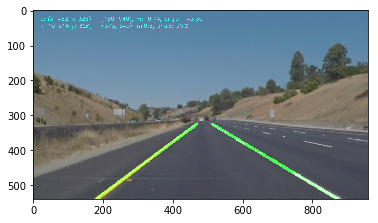

In [38]:
#TODO: Build your pipeline that will draw lane lines on the test_images
#then save them to the test_images directory

for img_file in img_files:
    inp_file = test_img_dir + img_file
    if os.path.isdir(inp_file):
        continue
        
    print('Now processing input image: ', inp_file)
    image = mpimg.imread(inp_file)

    # step1: gray scale the image
    img = grayscale(image)

    # step2: Find the edges using canny edge detection
    low_threshold=100
    high_threshold=300
    img = canny(img, low_threshold, high_threshold)
    img = gaussian_blur(img, 5)

    #step 3 filter out the region of interest
    x=img.shape[1]
    y=img.shape[0]
    #print('x:', x, ', y: ', y)
    triangle = np.array([[0, y], [x/2-10, y/2+50], [x/2+10, y/2+50], [x, y],], np.int32)
    img = region_of_interest(img, [triangle])

    #step 4: draw hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    img, frame_info = hough_lines(None, img, rho, theta, threshold, min_line_len, max_line_gap)

    #step 5 super impose the lines got, on the original image 
    img = weighted_img(img, image)

    # test print locally
    plt.imshow(img)
    #write the image to a file
    out_file = test_img_dir + "out/" + img_file
    print("saving marked image to", out_file)
    cv2.imwrite(out_file, img)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [39]:
#To fix the error
#import imageio
#imageio.plugins.ffmpeg.download()
#Once fixed -- don't need the above
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [40]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # step1: gray scale the image
    img = grayscale(image)

    # step2: Find the edges using canny edge detection
    low_threshold=100
    high_threshold=300
    img = canny(img, low_threshold, high_threshold)
    img = gaussian_blur(img, 5)

    #step 3 filter out the region of interest
    x=img.shape[1]
    y=img.shape[0]
    #print('x:', x, ', y: ', y)
    triangle = np.array([[0, y], [x/2-10, y/2+50], [x/2+10, y/2+50], [x, y],], np.int32)
    img = region_of_interest(img, [triangle])

    #step 4: draw hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    global g_prev_frame
    img, g_prev_frame = hough_lines(g_prev_frame, img, rho, theta, threshold, min_line_len, max_line_gap)

    #step 5 super impose the lines got, on the original image 
    img = weighted_img(img, image)
    
    return img

Let's try the one with the solid white lane on the right first ...

In [41]:
global g_prev_frame
g_prev_frame=None
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:29<00:00,  8.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 3s, sys: 5.65 s, total: 1min 9s
Wall time: 31.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [43]:
global g_prev_frame
g_prev_frame=None
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:46<00:00,  6.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 26s, sys: 18.7 s, total: 3min 45s
Wall time: 1min 48s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [34]:
global g_prev_frame
g_prev_frame=None
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:57<00:00,  4.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 46s, sys: 9.08 s, total: 1min 55s
Wall time: 1min 1s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))